## COMP5623 Coursework on Image Classification with Convolutional Neural Networks 

Starter code.

In [0]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from  torch.utils.data import Dataset

import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from skimage import io, transform
from torch.autograd import Variable
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import csv
import timeit
import os
import math
import cv2

### Part I

The first part of the assignment is to build a CNN and train it on a subset of the ImageNet dataset. We will first create a dataframe with all the references to the images and their labels.

To download the images into your work environment, clone into a git respository containing the images.

In [2]:
! git clone https://github.com/MohammedAlghamdi/imagenet10.git

Cloning into 'imagenet10'...
remote: Enumerating objects: 10019, done.
remote: Total 10019 (delta 0), reused 0 (delta 0), pack-reused 10019
Receiving objects: 100% (10019/10019), 966.71 MiB | 55.32 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (10002/10002), done.


Check that the repository is there:

In [3]:
! ls

imagenet10  sample_data


In [0]:
root_dir = "imagenet10/train_set/"
class_names = [
  "baboon",
  "banana",
  "canoe",
  "cat",
  "desk",
  "drill",
  "dumbbell",
  "football",
  "mug",
  "orange",
]

A helper function for reading in images and assigning labels.

In [0]:
def get_meta(root_dir, dirs):
    """ Fetches the meta data for all the images and assigns labels.
    """
    paths, classes = [], []
    for i, dir_ in enumerate(dirs):
        for entry in os.scandir(root_dir + dir_):
            if (entry.is_file()):
                paths.append(entry.path)
                classes.append(i)
                
    return paths, classes

Now we create a dataframe using all the data.

In [0]:
# Benign images we will assign class 0, and malignant as 1
paths, classes = get_meta(root_dir, class_names)

data = {
    'path': paths,
    'class': classes
}

data_df = pd.DataFrame(data, columns=['path', 'class'])
data_df = data_df.sample(frac=1).reset_index(drop=True) # Shuffles the data

View some sample data.

In [7]:
print("Found", len(data_df), "images.")
data_df.head()

Found 9000 images.


,path,class
0,imagenet10/train_set/drill/n03239726_1686.JPEG,5
1,imagenet10/train_set/football/n04254680_2170.JPEG,7
2,imagenet10/train_set/drill/n03239726_19589.JPEG,5
3,imagenet10/train_set/desk/n03179701_46928.JPEG,4
4,imagenet10/train_set/banana/n07753592_7578.JPEG,1


Now we will create the Dataset class.

In [0]:
class ImageNet10(Dataset):
    """ ImageNet10 dataset. """

    def __init__(self, df, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images
            df (DataFrame object): Dataframe containing the images, paths and classes
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load image from path and get label
        x = Image.open(self.df['path'][index])
        try:
          x = x.convert('RGB') # To deal with some grayscale images in the data
        except:
          pass
        y = torch.tensor(int(self.df['class'][index]))

        if self.transform:
            x = self.transform(x)

        return x, y

Compute what we should normalise the dataset to.

In [0]:
def compute_img_mean_std(image_paths):
    """
        Author: @xinruizhuang. Computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means, stdevs


In [10]:
#norm_mean, norm_std = compute_img_mean_std(paths)

 19%|█▉        | 1717/9000 [00:08<00:34, 212.09it/s]


KeyboardInterrupt: ignored

In [0]:
norm_mean = [0.5228344, 0.47988218, 0.40605018]
norm_std = [0.29770824, 0.28884, 0.31178245]

Now let's create the transforms to normalise and turn our data into tensors.

In [0]:
data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

Let's split the data into train and test sets and instantiate our new ISIC_Dataset objects.

In [0]:
train_split = 0.70 # Defines the ratio of train/valid/test data.
valid_split = 0.10

train_size = int(len(data_df)*train_split)
valid_size = int(len(data_df)*valid_split)

ins_dataset_train = ImageNet10(
    df=data_df[:train_size],
    transform=data_transform,
)

ins_dataset_valid = ImageNet10(
    df=data_df[train_size:(train_size + valid_size)].reset_index(drop=True),
    transform=data_transform,
)

ins_dataset_test = ImageNet10(
    df=data_df[(train_size + valid_size):].reset_index(drop=True),
    transform=data_transform,
)

You will need to create DataLoaders for the datasets.

In [0]:
train_loader = torch.utils.data.DataLoader(
    ins_dataset_train,
    batch_size=16,
    shuffle=True,
    num_workers=2
)


test_loader = torch.utils.data.DataLoader(
    ins_dataset_test,
    batch_size=32, # Forward pass only so batch size can be larger
    shuffle=False,
    num_workers=2
)

val_loader = torch.utils.data.DataLoader(
    ins_dataset_valid, 
    batch_size=16,
    shuffle=True,  
    num_workers=2)

classes=np.arange(0,10)


A framework for the ConvNet model, missing all layers except the final fully-connected layer:

In [14]:
# Convolutional neural network
class ConvNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
  
        # Add network layers here
        self.conv1=torch.nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            torch.nn.Dropout(0.6)
        )


        self.conv2=torch.nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels=24,kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            torch.nn.Dropout(0.6)
        )

        self.conv3=torch.nn.Sequential(
           nn.Conv2d(in_channels=24,out_channels=32,kernel_size=5),
           nn.ReLU(),
           nn.MaxPool2d(kernel_size=2,stride=2),
           torch.nn.Dropout(0.5)
        )

        self.conv4=torch.nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            torch.nn.Dropout(0.6)
        )
      
        
        self.fc1 = nn.Linear(9216,512)   # 8*8*128
        self.fc2 = nn.Linear(512,num_classes)

    def forward(self, x):

        # Complete the graph
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        # out = x.reshape(x.size(0), -1) # TODO what does this do? Why do we need it?
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.fc2(out)

        return out
      
net = ConvNet()
print(net)


ConvNet(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.6, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.6, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(24, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.6, inplace=False)
  )
  (fc1): Linear(in_features=9216, out_features=512, bias=True)
  (fc2): Linear(in_features=5

In [15]:
# Device configuration - defaults to CPU unless GPU is available on device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [0]:
model_gpu=ConvNet().to(device)

In [0]:
import torch.optim as optim          
 
criterion = nn.CrossEntropyLoss()    
optimizer = optim.SGD(model_gpu.parameters(), lr=0.1, momentum=0.9)   #optim模块中的SGD梯度优化方式---随机梯度下降


In [0]:
t_loss = []
v_loss = []
epochs = []
""" Trains the model for a given number of epochs on the training set. """
def train_model_epochs(num_epochs):
     for epoch in range(num_epochs):
      
          train_loss=0.0
          for i, data in enumerate(train_loader, 0):
               images, labels = data

               images = images.to(device)
               labels = labels.to(device)

               # Zero the parameter gradients means to reset them from
               # any previous values. By default, gradients accumulate!
               optimizer.zero_grad()

               # Passing inputs to the model calls the forward() function of
               # the Module class, and the outputs value contains the return value
               # of forward()
               outputs = model_gpu(images)

               # Compute the loss based on the true labels
               loss = criterion(outputs, labels)

               # Backpropagate the error with respect to the loss
               loss.backward()

               # Updates the parameters based on current gradients and update rule;
               # in this case, defined by SGD()
               optimizer.step()

               # Print our loss
               train_loss += loss.item()
               if i % 100 == 99:    # print every 100 mini-batches
                   print('Epoch / Batch [%d / %d] - train_Loss: %.3f' %
                         (epoch + 1, i + 1, train_loss / 1000))
                   t_loss.append(train_loss / 1000)
                   train_loss = 0.0
          

    
          total_val_loss = 0
          for j,val_data in enumerate(val_loader,0):
              # Wrap tensors in Variables
              inputs, labels = val_data

              inputs = inputs.to(device)
              labels = labels.to(device)
 
              # Forward pass
              val_outputs = model_gpu(inputs)

              val_loss = criterion(val_outputs, labels)
             
              total_val_loss += val_loss.item()
              if j % 10 == 9:                         # print every 100 mini-batches
                   print('Epoch / Batch [%d / %d] - Val_Loss: %.3f' %
                        (epoch + 1, j + 1, total_val_loss / 100))
                   v_loss.append(total_val_loss / 100)
                   total_val_loss = 0.0
                            

In [19]:
# train_model_epochs(num_epochs)

gpu_train_time = timeit.timeit(
    "train_model_epochs(num_epochs)",
    setup="num_epochs=10",
    number=1,
    globals=globals(),
)

Epoch / Batch [1 / 100] - train_Loss: 0.264
Epoch / Batch [1 / 200] - train_Loss: 0.237
Epoch / Batch [1 / 300] - train_Loss: 0.234
Epoch / Batch [1 / 10] - Val_Loss: 0.240
Epoch / Batch [1 / 20] - Val_Loss: 0.234
Epoch / Batch [1 / 30] - Val_Loss: 0.238
Epoch / Batch [1 / 40] - Val_Loss: 0.234
Epoch / Batch [1 / 50] - Val_Loss: 0.237
Epoch / Batch [2 / 100] - train_Loss: 0.233
Epoch / Batch [2 / 200] - train_Loss: 0.231
Epoch / Batch [2 / 300] - train_Loss: 0.233
Epoch / Batch [2 / 10] - Val_Loss: 0.231
Epoch / Batch [2 / 20] - Val_Loss: 0.232
Epoch / Batch [2 / 30] - Val_Loss: 0.229
Epoch / Batch [2 / 40] - Val_Loss: 0.231
Epoch / Batch [2 / 50] - Val_Loss: 0.230
Epoch / Batch [3 / 100] - train_Loss: 0.232
Epoch / Batch [3 / 200] - train_Loss: 0.232
Epoch / Batch [3 / 300] - train_Loss: 0.232
Epoch / Batch [3 / 10] - Val_Loss: 0.234
Epoch / Batch [3 / 20] - Val_Loss: 0.231
Epoch / Batch [3 / 30] - Val_Loss: 0.230
Epoch / Batch [3 / 40] - Val_Loss: 0.233
Epoch / Batch [3 / 50] - Val_L

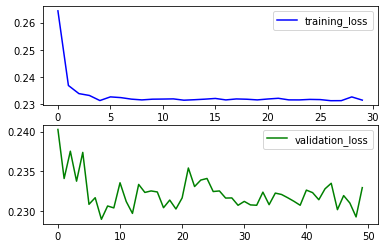

In [21]:
plt.figure('training_loss VS validation_loss')
plt.subplot(211)
plt.plot(range(len(t_loss)),t_loss,color='blue',label='training_loss')
plt.legend()
plt.subplot(212)
plt.plot(range(len(v_loss)),v_loss,color='green',label='validation_loss')
plt.legend()
plt.show()



In [22]:
# test model， 测试模型
correct = 0
total = 0

# Why don't we need gradients? What happens if we do include gradients?
with torch.no_grad():

    # Iterate over the test set
    for data in test_loader:
          images, labels = data
          
          images = images.to(device)
          labels = labels.to(device)

          outputs = model_gpu(images)

          # torch.max is an argmax operation
          _, predicted = torch.max(outputs.data, 1)

          total += labels.size(0)
          correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))


Accuracy of the network on the test images: 10 %


In [0]:
torch.save(model_gpu,'./my_mnist_model.pt')

In [0]:
cm = confusion_matrix(labels.cpu(), predicted.cpu()) 
cm

In [0]:
import itertools

def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix very prettily.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    # Specify the tick marks and axis text
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    # The data formatting
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Print the text of the matrix, adjusting text colour for display
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [0]:
plot_confusion_matrix(cm, classes)

**第二题，好像是这样做。。。。。**

In [0]:
# 可视化卷积核在训练前，训练中，训练后  

import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=True, nrow=6, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: 
      tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)),cmap="gray")


f = model_gpu.conv1[0].weight.cpu().detach().clone()
# filter1 = net.conv1[0].weight.data.clone()
visTensor(f, ch=0, allkernels=True)
plt.show()

**第三题，可视化原始图像，第一层卷积中的4张图像，（卷积后，激活函数后，maxpooling后，dropout后）。。。。。**

In [0]:
for data in test_loader:
      images, labels = data

print(type(images))

images1 = images.numpy()

img = np.squeeze(images1)
print(img.shape)
img = img[0,:,:,:]
print(img.shape)
pic = np.rollaxis(img,0,3)
# print(pic.shape)

plt.imshow(pic)

In [0]:
#定义用于hook的类
class LayerActivations():
	#定义这个变量用于储存结果
	features = None
	#类初始化。当前向传播的时候（即图像数据通过层传输的时候），调用register_forward_hook方法。
	#register_forward_hook方法即为[钩子]，此方法返回一个句柄保存到self.hook
	def __init__(self,model,layer_num):
		self.hook = model[layer_num].register_forward_hook(self.hook_fn)
	#hook函数具体执行的方法，即hook方法
	#register_forward_hook将三个参数传入hook_fn方法内
	#module:允许访问层本身 input:流进层的数据 output:层变换后的流出的数据或激活
	def hook_fn(self,module,input,output):
		#将输出保存到[自己设置的features变量中]
		self.features = output.cpu()
	#注销句柄self.hook
	def remove(self):
		self.hook.remove()

#定义hook类实例
conv_out = LayerActivations(net.conv2,0)  # 提出第一个卷积层的输出 

#运行模型
output = net(images)
#注销函数
conv_out.remove()

# 在hook class中被保存到了features变量的即为输出，自己定义的
activations = conv_out.features
#activations 即为层输出

#对其进行可视化
fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(left=0,right=1,bottom=0,top=0.8,hspace=0,wspace=0.2)
for i in range(30):
   ax = fig.add_subplot(12,5,i+1,xticks=[],yticks=[])
   ax.imshow(activations[0][i].detach().numpy())
plt.show()